# NE 204 Lab 1 Analysis
## Kalie Knecht
Lab Partners: Ian Kolaja, Trevor Arino, and <s>Karishma Shah</s>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
from spectrum import gaussian

# import tool repo
import sys


# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
from spectrum import spectrum

## import data

In [2]:
# # function imports data, removes duplicate events, and converts to np.int16
# # type conversion to np.int16 takes some time


print('cs calibration')
f_name = './data/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

print('co calibration')
f_name = './data/co.h5'
f_data = h5py.File(f_name,'r')
co = f_data['raw_data'][()]
co_events = f_data['event_data'][()]
print(str(co.shape[0])+' events')

print('ba calibration')
f_name = './data/ba.h5'
f_data = h5py.File(f_name,'r')
ba = f_data['raw_data'][()]
ba_events = f_data['event_data'][()]
print(str(ba.shape[0])+' events')

# pulser noise data
# f_name = './data/pulser.h5'
# f_data = h5py.File(f_name,'r')
# noise = f_data['raw_data'][()]
# noise_events = f_data['event_data'][()]
# print(str(noise.shape[0])+' events')

cs calibration
152057 events
co calibration
138945 events
ba calibration
8822 events
5634 events


## Calibration source information
* Cs-137
    * 10.2 $\mu$Ci, 377.4 kBq, 1-Jun-13
    * half life: 30.08(9) y (NNDC)
    * source strength on 10/28/22: 8.21 $\mu$Ci
    * Associated gamma-ray energy:
        * 662 keV, 85.10(20) %
* Co-60 
    * 9.947 $\mu$Ci, 368.0 kBq, 15-Mar-12
    * source strength on 10/28: 2.46 $\mu$Ci
    * Half life: 1925.28(14) d (NNDC) 
    * Associated gamma-ray energies (NNDC):
        * 1173.228(3) keV, 99.85(3)%
        * 1332.492(4) keV, 99.9826(20)%
* Ba-133 
    * 10.57 $\mu$Ci, 391.1 kBq, 15-Mar-12
    * source strength on 10/28: 5.26 $\mu$Ci
    * Half life: 10.551(11) y (NNDC)
    * Associated gamma-ray energy (NNDC):
        * 383.9 keV, 8.94%
        
        
Old picture, but I used the plastic sources:
<img src="figs/IMG_9241.jpg" alt="sources" width="300"/>

In [325]:
# find source activties during measurement
# function syntax (half-life, initial activity, time since born date (in units of half-life))
# function output: activity during measurement in units of initial activity
print('Cs137')
Acs = find_activity(30.09,10.2,9 + 4/12 + 27/365.25)
print('10/28: ',Acs)
print('----------------------------')
print('Co60')
Aco = find_activity(1925.28,9.947,10*365.25 + 7*30.5 + 13)
print('10/28: ',Aco)
print('----------------------------')
print('Ba133')
Aba= find_activity(10.551,10.57,10 + 7/12 + 13/365.25)
print('10/28: ',Aba)

Cs137
10/28:  8.212719257704487
----------------------------
Co60
10/28:  2.4614178653154752
----------------------------
Ba133
10/28:  5.261469000987922


## Plot raw waveforms
From plotting we can see some additional cleanup is necessary

In [438]:
# convert waveform time scale to nanoseconds
wave_times = np.linspace(0,1/(250*10**6)*50000*10**9,50000)

array([ 383.8485,  661.7   , 1173.228 , 1332.492 ])

<IPython.core.display.Javascript object>


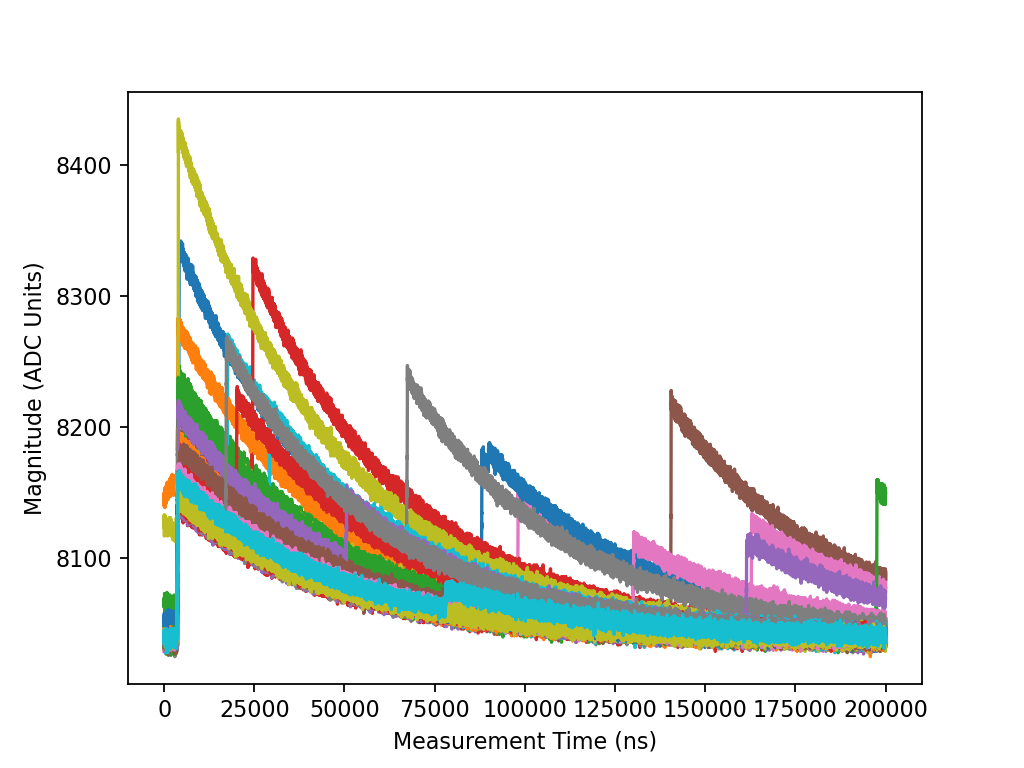

In [485]:
# plot random pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs))
    plt.plot(wave_times,cs[n])
#plt.xlim(920,1150)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.show()

# apply trapezoidal filter to raw waveform

In [475]:
# subtract baseline before finding exponential fit
cs_bkg = subtract_baseline(cs[::100])
# first downsample data a reasonable amount
cs_bkg.shape

(1521, 50000)

## fit tau

In [478]:
tauvals = fit_taus(cs_bkg)

# we can see we have a pretty large mean and standard deviation
# I expect tau to be around 12,000
# what is causing these high values?
tauvals.mean(), tauvals.std()

mean and variance: 980629861.1072853 1.651341148517282e+20


(980629861.1072853, 12850451931.808788)

<IPython.core.display.Javascript object>


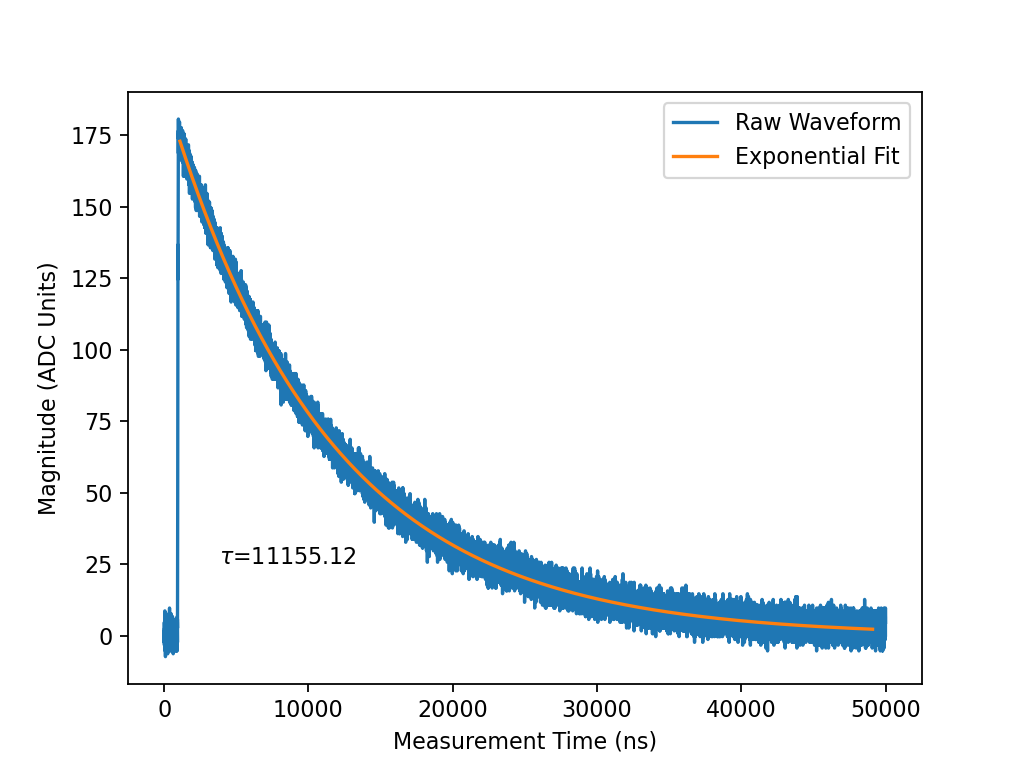

11155.124760950586

In [480]:
#plt.figure()
fit_tau(cs_bkg[0],show_plot=True,plot_save_name='fit_tau.png')
#plt.show()

In [486]:
# some tau values are really bad from pileup etc and mess up the average, 
# remove infeasible tau values and find average of remaining tau
mask = tauvals < 2e4 # less than 15000
mask *= tauvals > 5e3 # at least 1000
good_tau_pulses = cs_bkg[mask]
bad_tau_pulses = cs_bkg[~mask]

tau_fixed = fit_taus(good_tau_pulses)

mean and variance: 10967.425786005182 207115.1253952434


<IPython.core.display.Javascript object>


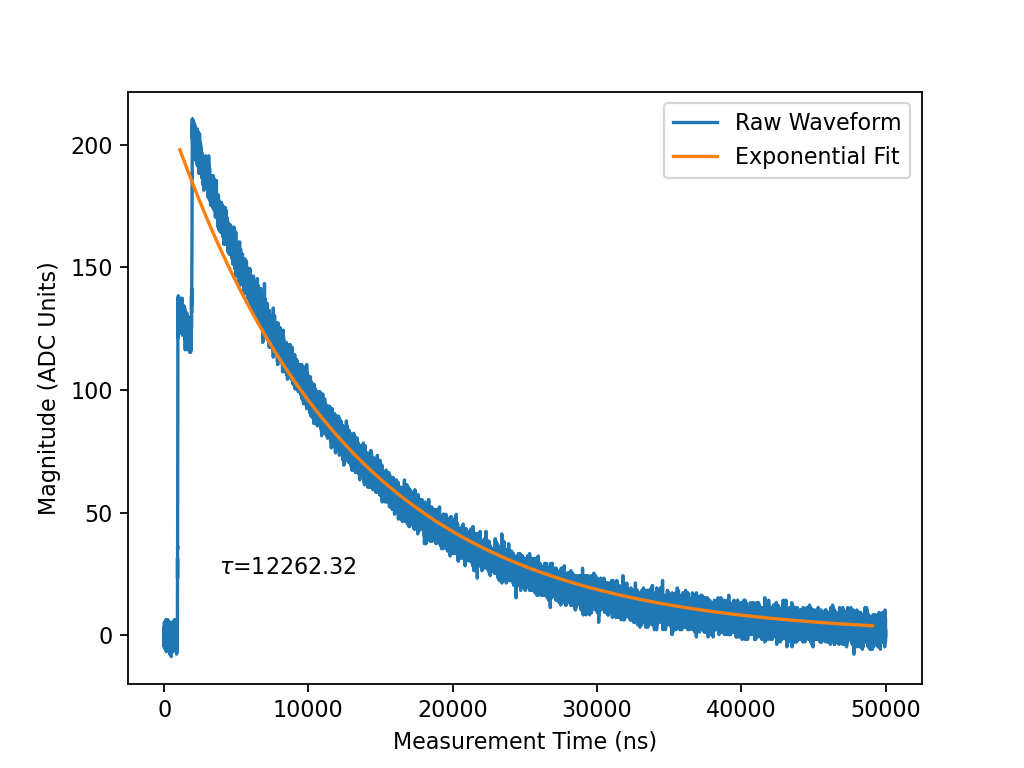

12262.315480218867

In [488]:
# example bad tau
fit_tau(bad_tau_pulses[0],show_plot=True)

In [449]:
# save as tau for filter
#tau = tau_fixed.mean()
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)

peaking_time = 100 * 4 * 10**(-9)
gap_time = peaking_time * 5  

print('Filter parameters:')
print('tau =',tau)
print('peaking time = ', peaking_time)
print('gap time = ', gap_time)

Filter parameters:
tau = 4.3869703144020734e-05
peaking time =  4.0000000000000003e-07
gap time =  2.0000000000000003e-06


In [4]:
# downsample data so filters can handle it
# maybe your computer is better than mine and you can remove the downsampling
cs_down = cs[::10]
print(len(cs_down))
ba_bkg_down = ba
print(len(ba_bkg_down))
co_bkg_down = co[::10]
print(len(co_bkg_down))

15206
8822
13895


In [180]:
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [181]:
filtered_cs = Cooper_filter.filter_waveform(cs_down,normalize=True)

In [184]:
filtered_ba = Cooper_filter.filter_waveform(ba_bkg_down,normalize=True)

In [185]:
filtered_co = Cooper_filter.filter_waveform(co_bkg_down,normalize=True)

In [186]:
all_filtered_waveforms = np.concatenate((filtered_cs,filtered_ba,filtered_co),axis=0)

<IPython.core.display.Javascript object>


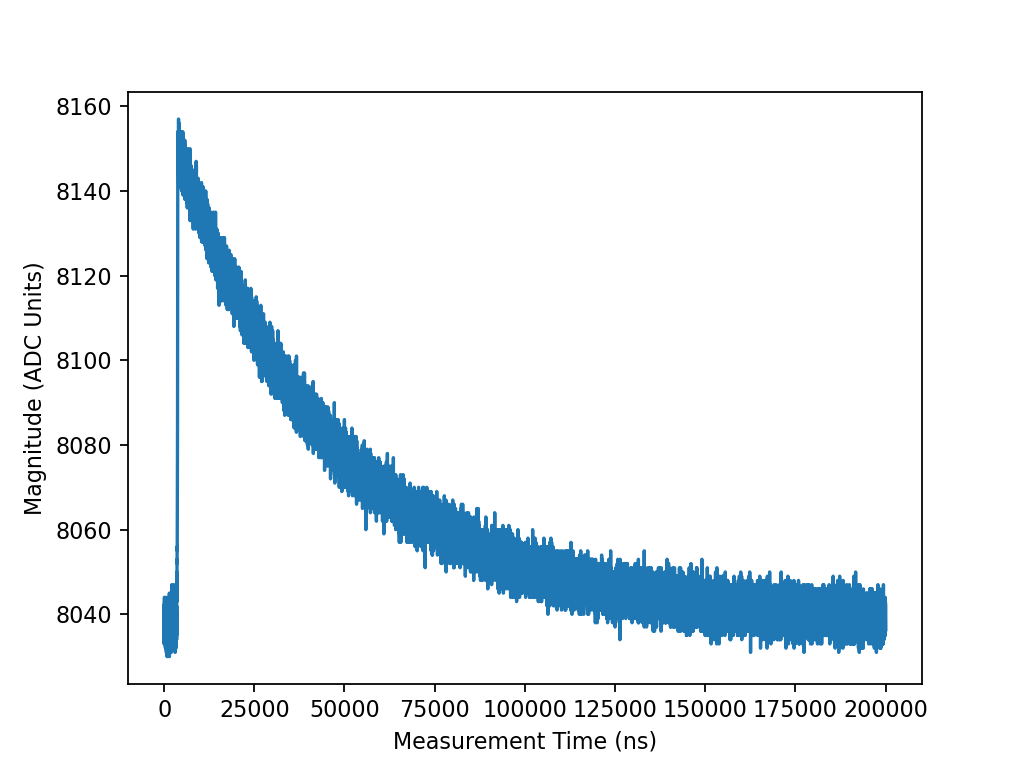

In [489]:
pulse_num = 10
plt.figure()
plt.plot(wave_times,cs_down[pulse_num])
plt.ylabel('Magnitude (ADC Units)')
plt.xlabel('Measurement Time (ns)')
#plt.title('Raw Waveform')
plt.savefig('figs/example_pulse_raw.png')
plt.show()

<IPython.core.display.Javascript object>


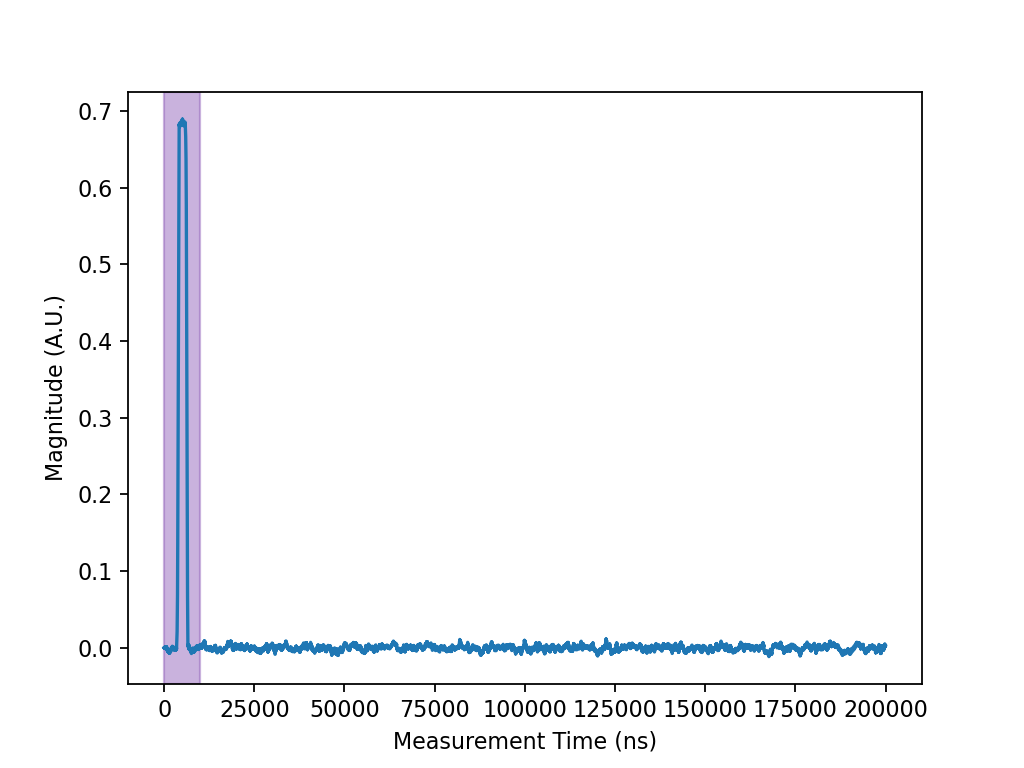

In [490]:
plt.figure()
plt.plot(wave_times,filtered_cs[pulse_num])
plt.axvspan(0,10000,color='tab:purple',alpha=0.5)
plt.ylabel('Magnitude (A.U.)')
plt.xlabel('Measurement Time (ns)')
#plt.title('Filtered Waveform')
plt.savefig('figs/example_pulse_filtered.png')
plt.show()

<IPython.core.display.Javascript object>


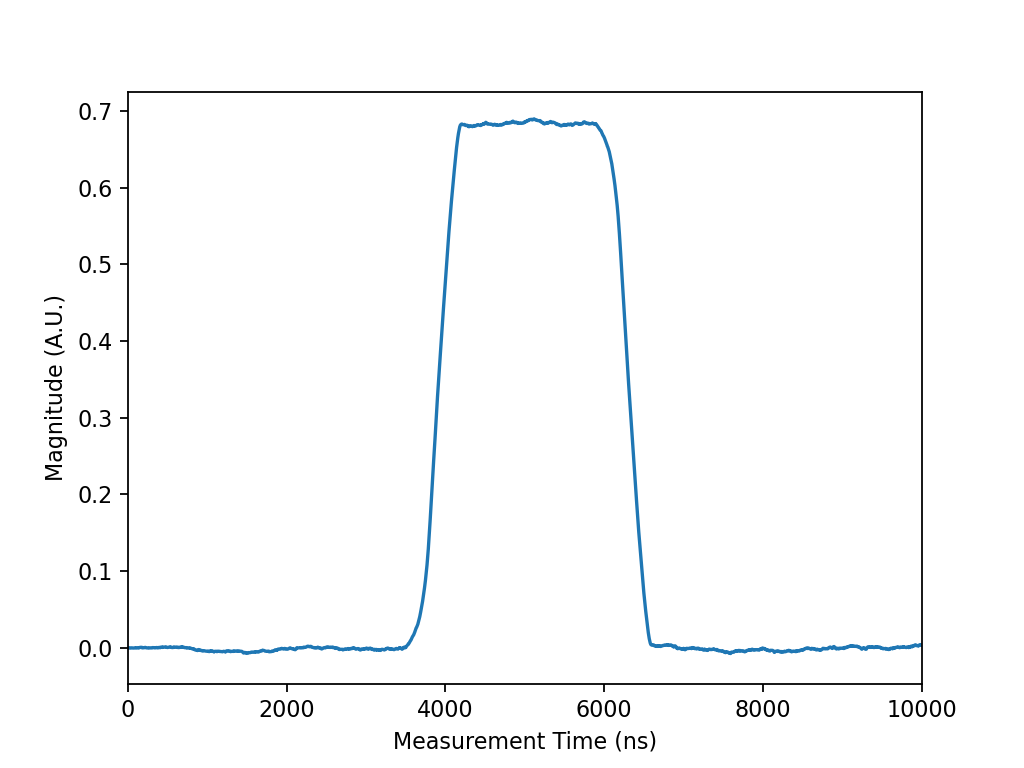

In [491]:
plt.figure()
plt.plot(wave_times,filtered_cs[pulse_num])
plt.xlim(0,10000)
plt.ylabel('Magnitude (A.U.)')
plt.xlabel('Measurement Time (ns)')
plt.savefig('figs/example_pulse_filtered_zoomed.png')
plt.show()

<IPython.core.display.Javascript object>


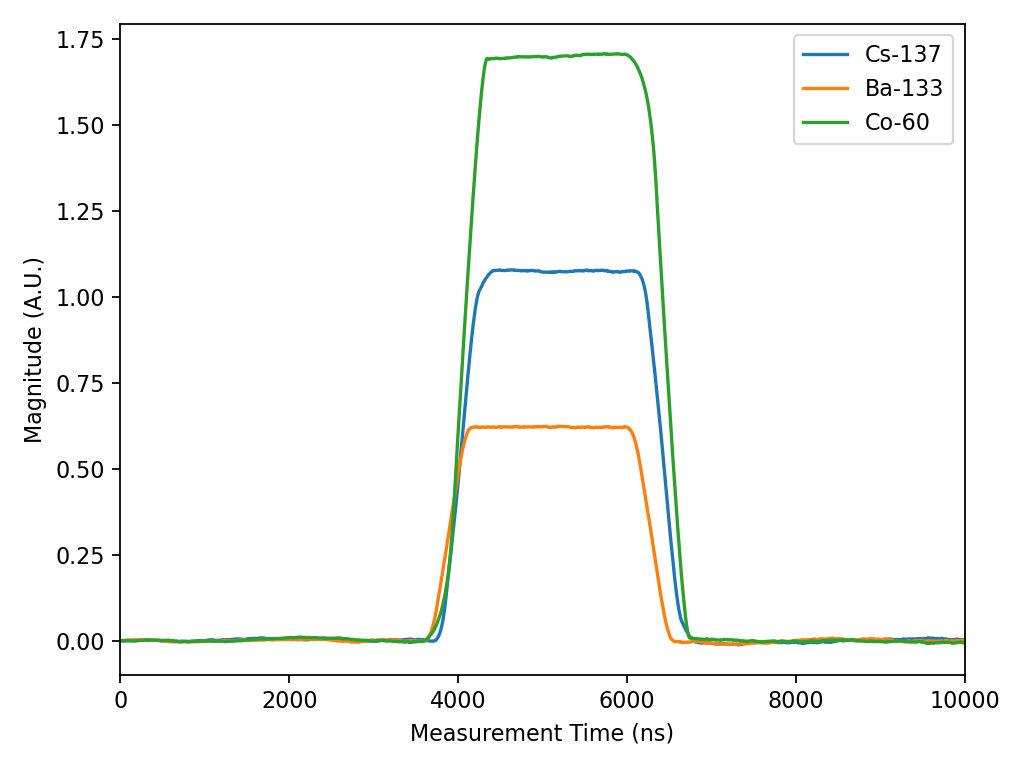

In [493]:
plt.figure()
plt.plot(wave_times,filtered_cs[12],label='Cs-137')
plt.plot(wave_times,filtered_ba[6],label='Ba-133')
plt.plot(wave_times,filtered_co[0],label='Co-60')
plt.xlim(0,10000)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (A.U.)')
#plt.title('Example Trapezoid Filtered Pulses from Individual Source Measurements')
plt.legend()
plt.tight_layout()
plt.savefig('figs/all_sources_trapezoids.png')
plt.show()

# Spectral analysis
## Load data into a spectrum

In [452]:
# load filtered waveforms into 'spectrum'
spec = spectrum(all_filtered_waveforms,bins=2000)

<IPython.core.display.Javascript object>


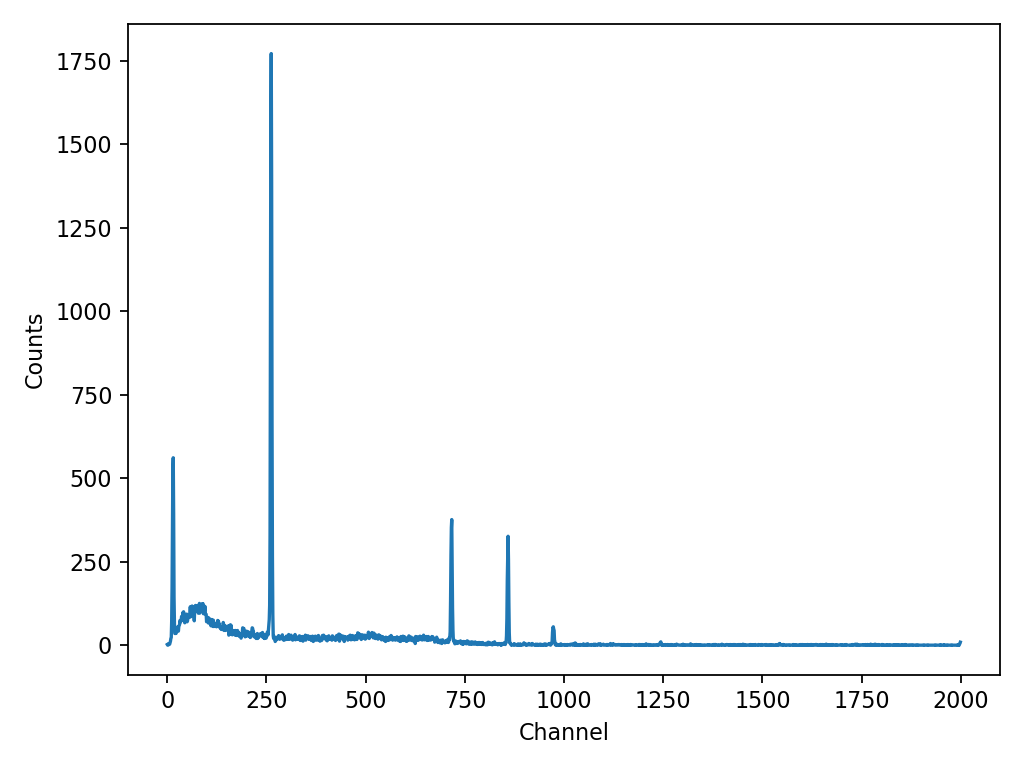

In [453]:
# spectrum histograms trapezoid into a spectrum
spec.plot_spectrum(energy=False,show_calibrated_peaks=False, plot_savefile='figs/channel_spec.png')

## Perform Energy Calibration

Finding Peaks


<IPython.core.display.Javascript object>


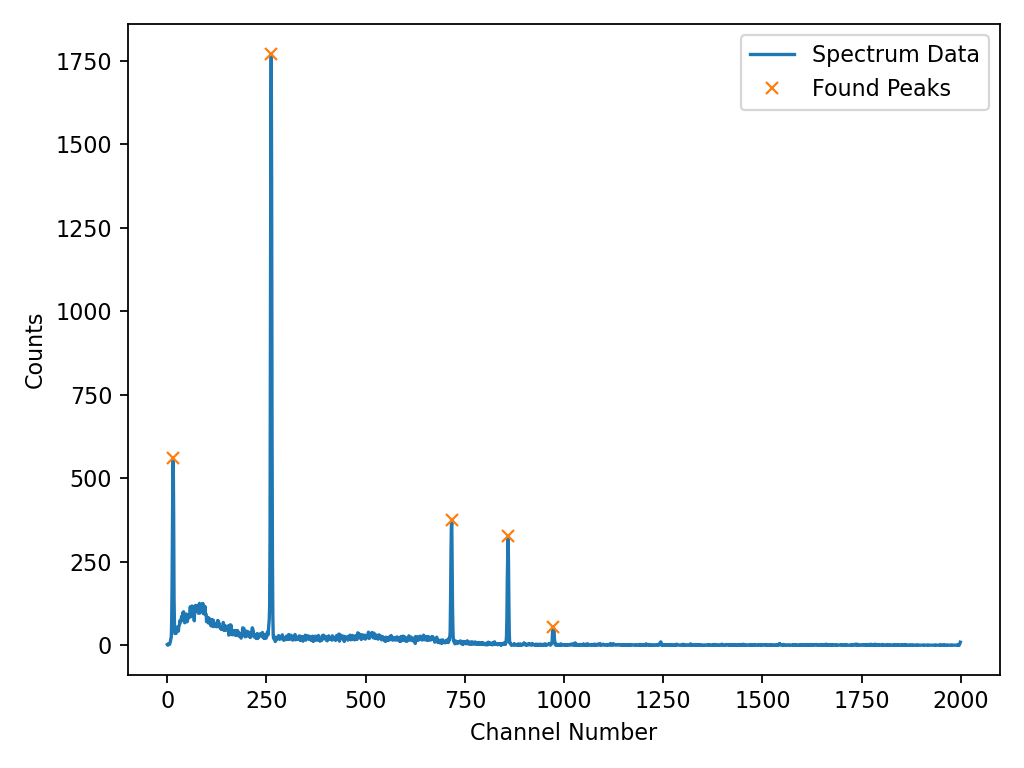

In [454]:
# find gamma peaks
spec.find_gamma_peaks(show_plot=True,prominence=50,width=[0,10],plot_savefile='figs/find_peaks.png')

Fitting gaussian


<IPython.core.display.Javascript object>


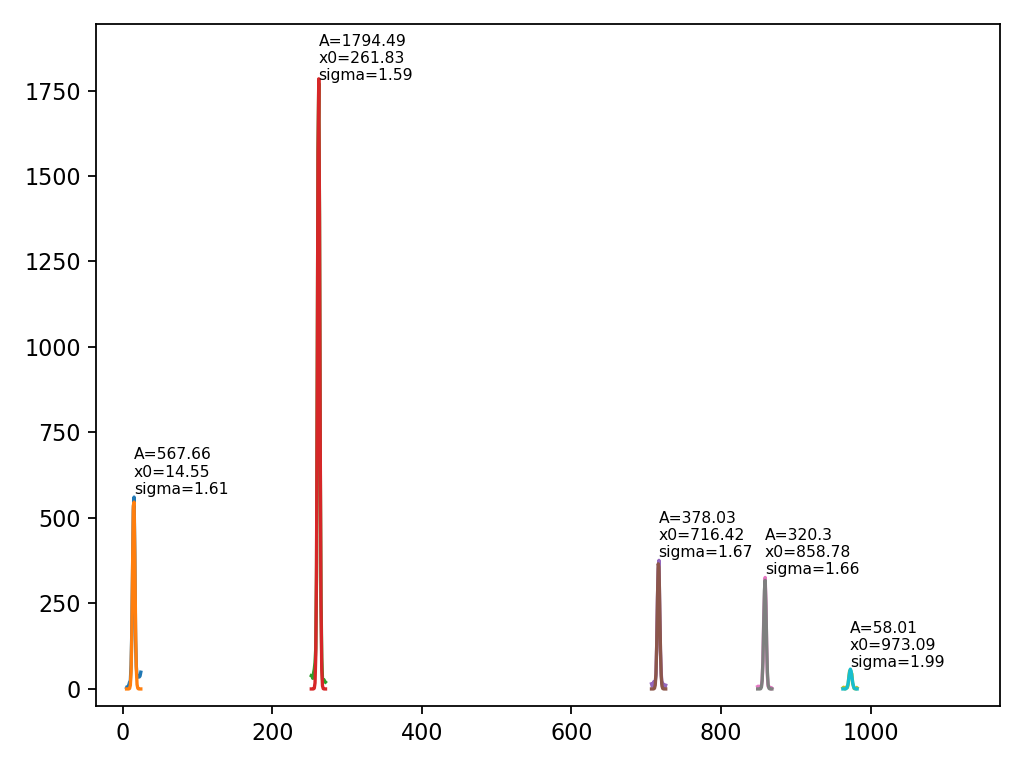

In [455]:
# perform gaussian fit to refine peak positions, find sigma, and counts in peaks
spec.fit_gaussian(show_plot=True,show_fitvalues=True)

In [458]:
# relevant gamma energies
# energies=[356.0129, 661.7,  1173.228, 1332.492]
# compton_edges = np.array([477.,963.,1118.])
# # k40 and tl208
# background_peaks = np.array([1460.820,1764,2614.511])
# possible_pileups = np.array([1173.228+1332.492,662*2,1173.228*2,1332.492*2])

# energies = [356.0129, 661.7,  1173.228, 1332.492, 1460.820]
energies = [383.8485, 661.7,  1173.228, 1332.492, 1460.820]

# provide energies of gamma peaks selected by peak fitting algorithm
spec.find_energy_calibration(energies=energies,alternative='greater')

Finding energy calibration


<IPython.core.display.Javascript object>


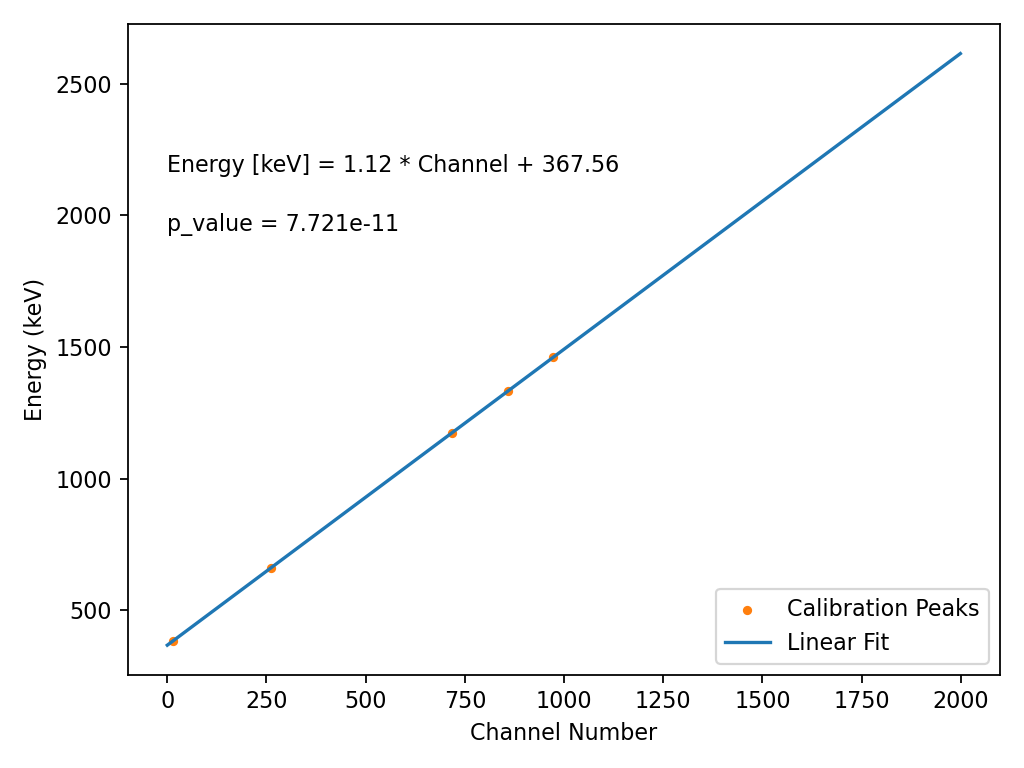

Energy [keV] = 1.12 * Channel + 367.56


In [459]:
# visualize energy calibration
# zoom in for error bars
spec.plot_energy_calibration(show_equation=True,plot_savefile='figs/energy_cal.png')

<IPython.core.display.Javascript object>


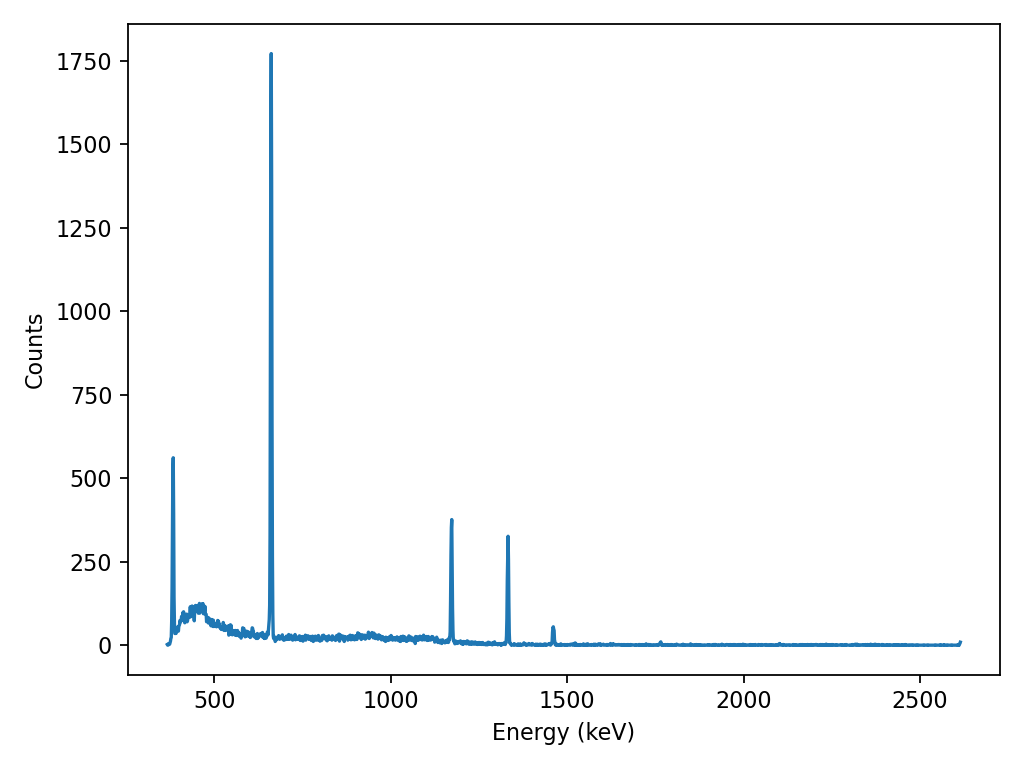

In [460]:
# see spectrum with x-axis as energy
spec.plot_spectrum(show_calibrated_peaks=False,plot_savefile='figs/energy_cal_spectra.png')

In [461]:
# check that expected energies are close to fit energies
fitted_energies = energies
#fitted_energies.append(background_peaks[0])

print(np.isclose(fitted_energies,spec.bin_energies[spec.peaks],atol=5))
fitted_energies - spec.bin_energies[spec.peaks]

[ True  True  True  True  True]


array([-0.56746442, -0.28754363, -0.0756106 , -0.38717435, -0.16913399])

<IPython.core.display.Javascript object>


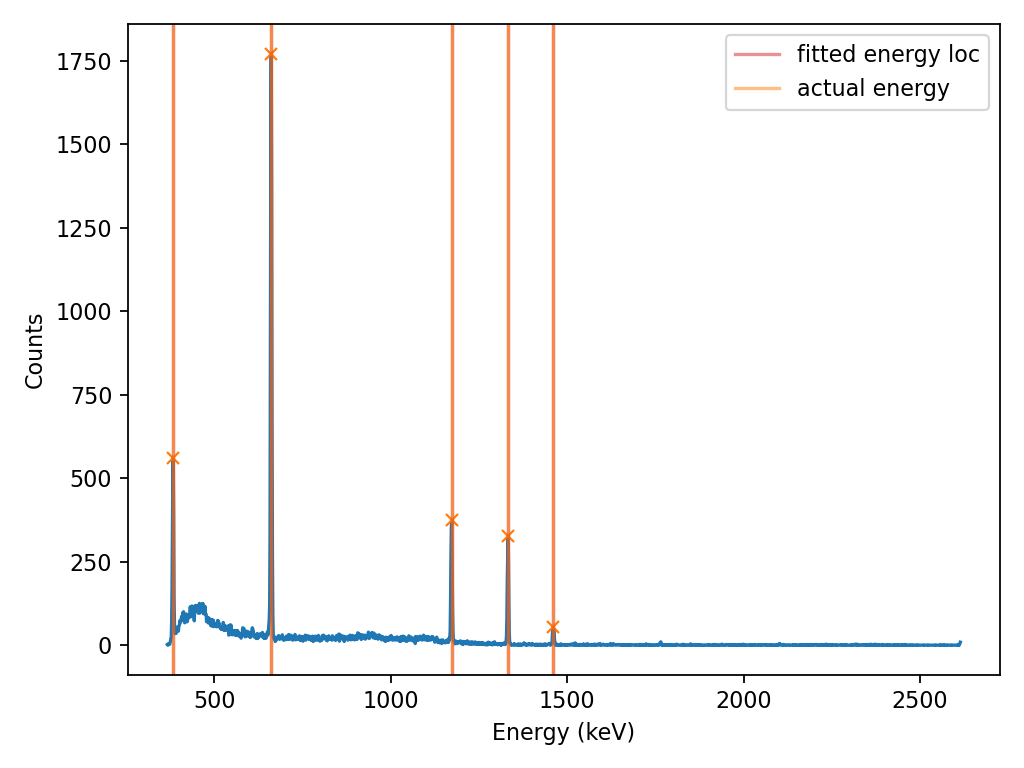

In [462]:
# see deviations from expected energy
# see spectrum with x-axis as energy
spec.plot_spectrum()
plt.axvline(spec.bin_energies[spec.peaks[0]],c='tab:red',alpha=0.5,label='fitted energy loc')
plt.axvline(fitted_energies[0],c='tab:orange',alpha=0.5,label='actual energy')
for i in range(len(spec.peaks)-1):
    plt.axvline(spec.bin_energies[spec.peaks[i+1]],c='tab:red',alpha=0.5)
    plt.axvline(fitted_energies[i+1],c='tab:orange',alpha=0.5)
plt.legend()

<IPython.core.display.Javascript object>


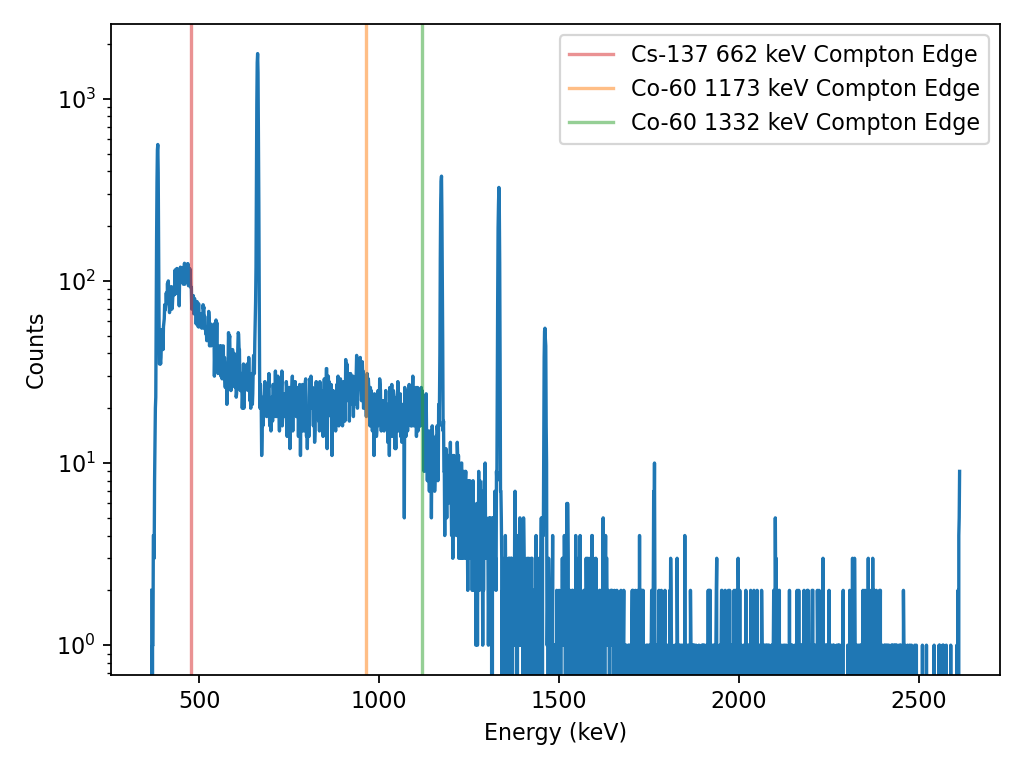

In [463]:
# highlight compton edges
spec.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.axvline(compton_edges[0],c='tab:red',alpha=0.5,label='Cs-137 662 keV Compton Edge')
plt.axvline(compton_edges[1],c='tab:orange',alpha=0.5,label='Co-60 1173 keV Compton Edge')
plt.axvline(compton_edges[2],c='tab:green',alpha=0.5,label='Co-60 1332 keV Compton Edge')
plt.legend()
plt.savefig('figs/spectrum_and_compton_edges.png')
# for i in range(len(compton_edges)):
#     plt.axvline(compton_edges[i],c='tab:red',alpha=0.5,label='Expected Compton Edges')

## Find Energy Resolution of Peaks

<IPython.core.display.Javascript object>


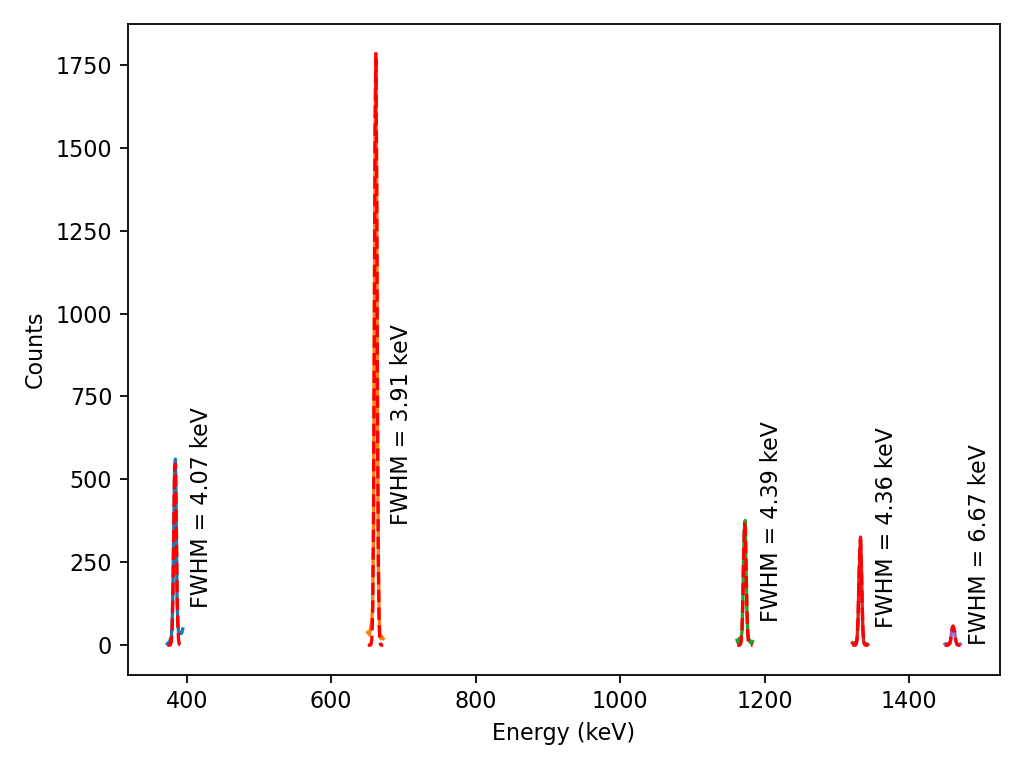

FWHMs = [4.06518889 3.91209526 4.38554584 4.35980873 6.67481928]


In [464]:
# find energy resolution (FWHM of peaks)
spec.find_fwhm(show_plot=True,show_fwhms=True,plot_savefile='figs/find_fwhm.png')
print('FWHMs =',spec.fwhms)

<IPython.core.display.Javascript object>


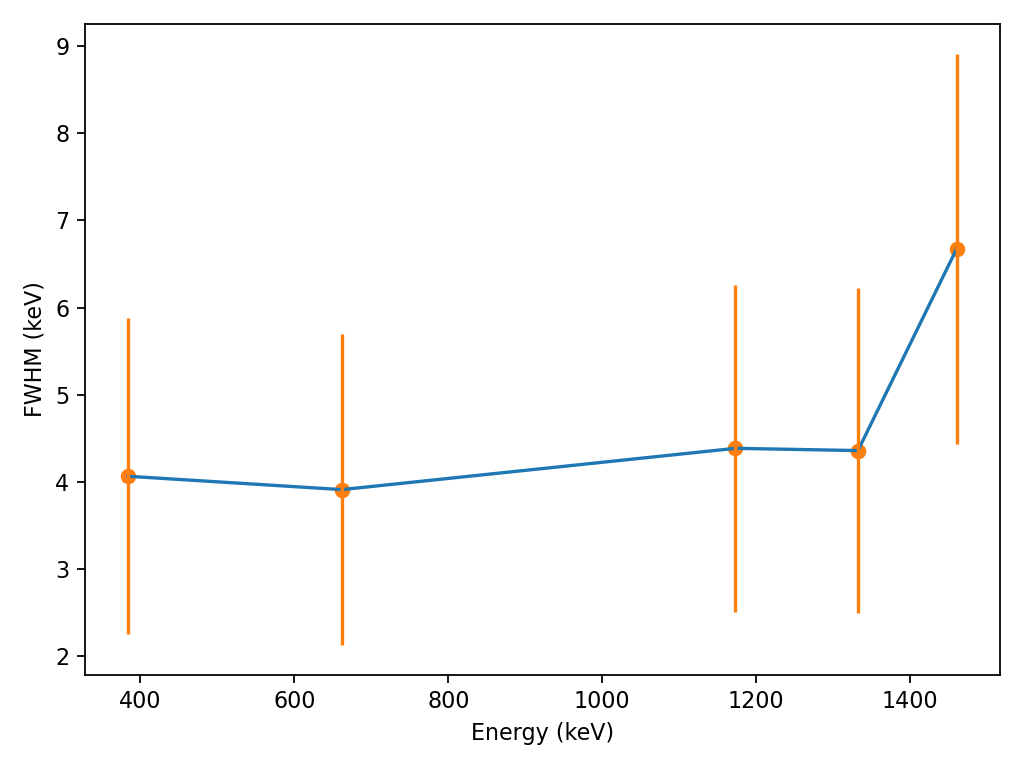

In [465]:
# plot fwhm vs energy
spec.plot_fwhms(plot_savefile='figs/fwhms_vs_energy.png')

In [466]:
# find energy resolution
# E_res = FWHM/Energy
spec.find_energy_resolution()

<IPython.core.display.Javascript object>


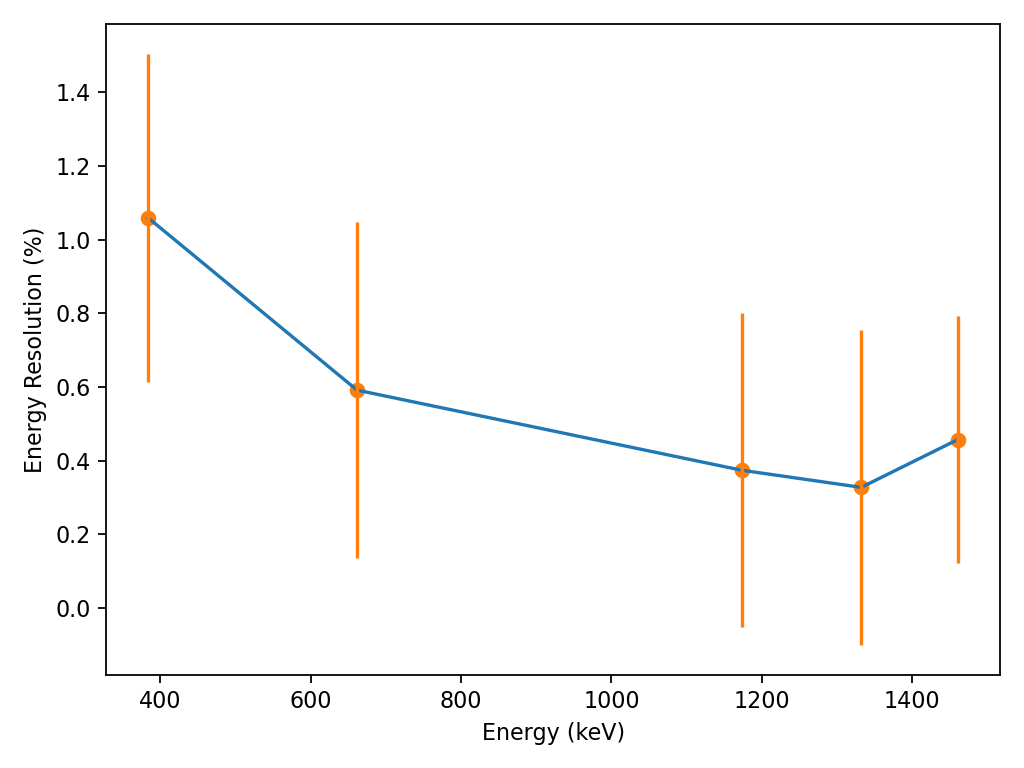

In [467]:
# visualize  FWHMs
spec.plot_energy_resolution(plot_savefile='figs/energy_res_vs_energy.png')
#plt.plot(spec.energies,-np.sqrt(spec.energies))

In [468]:
# find fano factor
# see pulser testing notebook for noise contribution calculation - built into code
spec.find_fano_factor(E_noise = 2.7187219507156715)
print('mean fano factor = ',round(spec.fano_factor.mean(),2),'+/-',round(spec.fano_factor.std(),2))

Finding Fano Factor
mean fano factor =  0.97 +/- 0.43


<IPython.core.display.Javascript object>


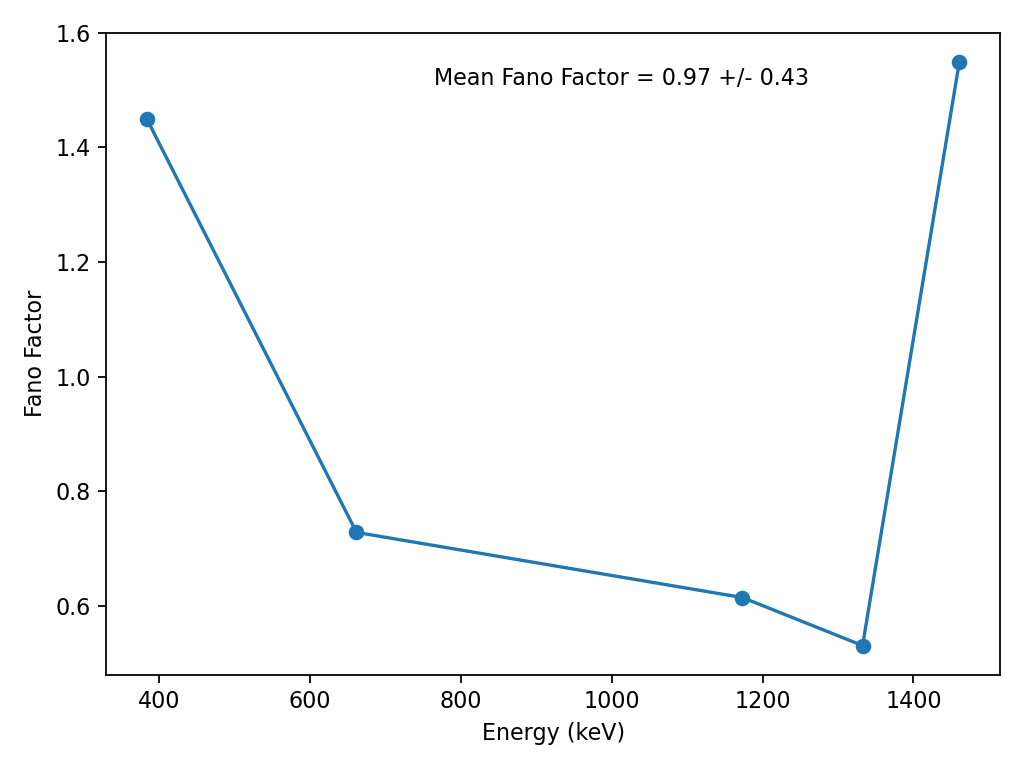

In [469]:
# plot fano factor
spec.plot_fano_factor(display_mean_fano=True,plot_savefile='figs/fano_wbkg.png')

# remove background peak for better looking performance

In [494]:
# IMPORTANT - ONLY RUN THIS CELL !!!!! ONCE !!!!
spec.peaks = np.delete(spec.peaks,4)
spec.energies = np.delete(spec.energies,4)
spec.fwhms = np.delete(spec.fwhms,4)
spec.sigma_E = np.delete(spec.sigma_E,4)

<IPython.core.display.Javascript object>


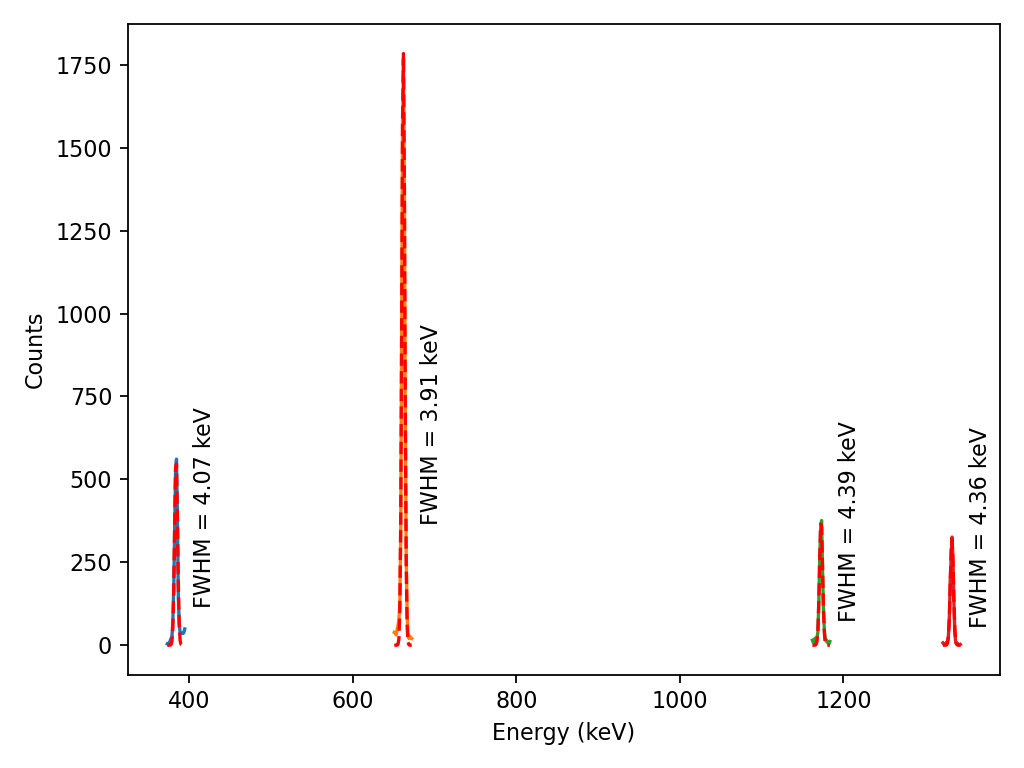

In [496]:
# find energy resolution (FWHM of peaks)
spec.find_fwhm(show_plot=True,show_fwhms=True,plot_savefile='figs/find_fwhm_nobkg.png')

<IPython.core.display.Javascript object>


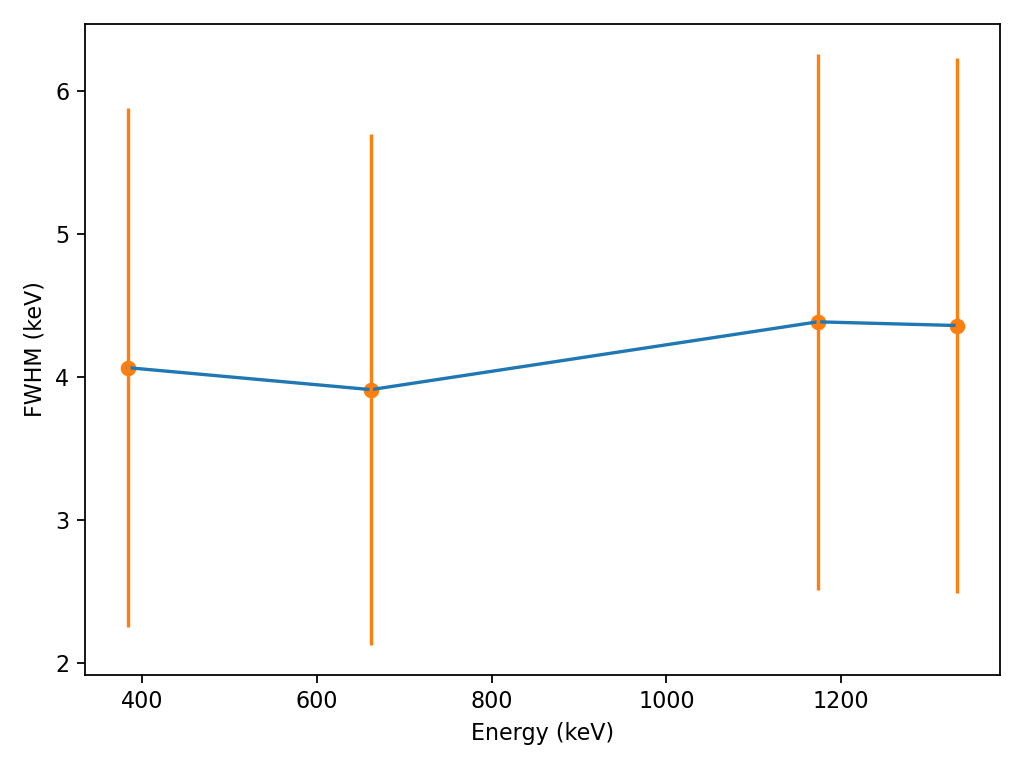

In [443]:
# plot fwhm vs energy
spec.plot_fwhms(plot_savefile='figs/fwhms_vs_energy_nobkg.png')

In [444]:
# find energy resolution (FWHM/E)
spec.find_energy_resolution()

<IPython.core.display.Javascript object>


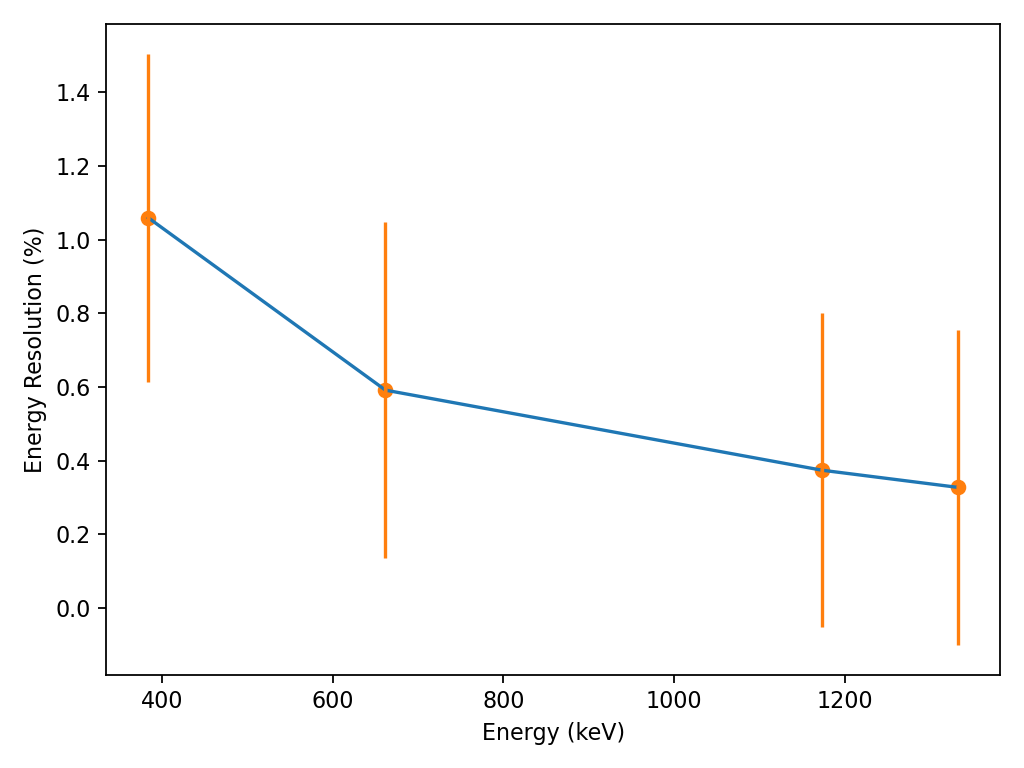

In [445]:
# plot energy resolution
spec.plot_energy_resolution(plot_savefile='figs/eres_nobkg.png')

In [446]:
# find fano factor
spec.find_fano_factor()

Finding Fano Factor


<IPython.core.display.Javascript object>


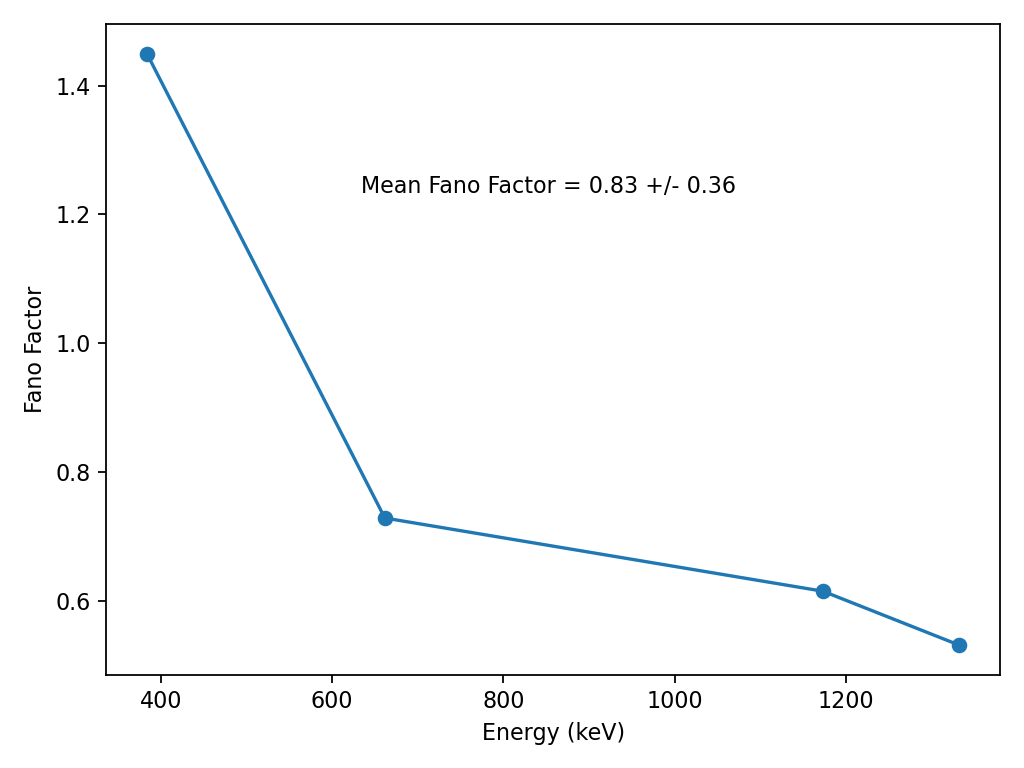

In [447]:
# plot fano factor
spec.plot_fano_factor(plot_savefile='fano_no_bkg.png',display_mean_fano=True)